In [1]:
import pandas as pd
import numpy as np
from typing import List, Dict
from sklearn.model_selection import train_test_split
import seaborn as sns
from utils.utils import *

global_rand_state = 66
cache = {}

In [2]:
# Initialize logging and save to a file
LOG_FILE = "mlflow_api.log"
initiate_logger(loc=LOG_FILE)

In [3]:
df = pd.read_csv("./data/air_pollution_dataset.csv")

In [4]:
target = 'Air Quality'
df[target].unique()

array(['Moderate', 'Good', 'Hazardous', 'Poor'], dtype=object)

In [5]:
global_map_ = {'Moderate':2, 'Good':3, 'Hazardous':0, 'Poor':1}

In [6]:
X_preprocessed, y_preprocessed, caches = data_preprocessing(location='./data/air_pollution_dataset', target='Air Quality', random_state=global_rand_state, )

{'features': {'numerical_means': {'Temperature': np.float64(30.029020000000003), 'Humidity': np.float64(70.05611999999999), 'PM2.5': np.float64(20.142139999999998), 'PM10': np.float64(30.218360000000004), 'NO2': np.float64(26.4121), 'SO2': np.float64(10.01482), 'CO': np.float64(1.5003540000000002), 'Proximity_to_Industrial_Areas': np.float64(8.4254), 'Population_Density': np.float64(497.4238)}, 'categorical_modes': {}}, 'target': {'numerical_mean': {}, 'categorical_mode': {'Air Quality': 'Good'}}}
{'z-score': {'skip_columns': ['PM2.5', 'PM10'], 'z_threshold': 3, 'mean': {'Temperature': np.float64(30.029020000000003), 'Humidity': np.float64(70.05611999999999), 'NO2': np.float64(26.4121), 'SO2': np.float64(10.01482), 'CO': np.float64(1.5003540000000002), 'Proximity_to_Industrial_Areas': np.float64(8.4254), 'Population_Density': np.float64(497.4238)}, 'std': {'Temperature': np.float64(30.029020000000003), 'Humidity': np.float64(70.05611999999999), 'NO2': np.float64(26.4121), 'SO2': np.flo

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X_preprocessed, 
                                        y_preprocessed, 
                                        shuffle=True, 
                                        test_size=0.2, 
                                        random_state=global_rand_state
                                    )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3869, 8), (3869,), (968, 8), (968,))

In [8]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()

X_train_scaled, X_test_scaled = scale_features(X_train=X_train, X_test=X_test, scaler=scl)

scaler_cache = {}
scaler_cache["scaler"] = scl
caches.append(scaler_cache)

# just to make sure everything is going well
assert (X_train.shape == X_train_scaled.shape) and (X_test.shape == X_test_scaled.shape), "Serious issue with feature scaling."

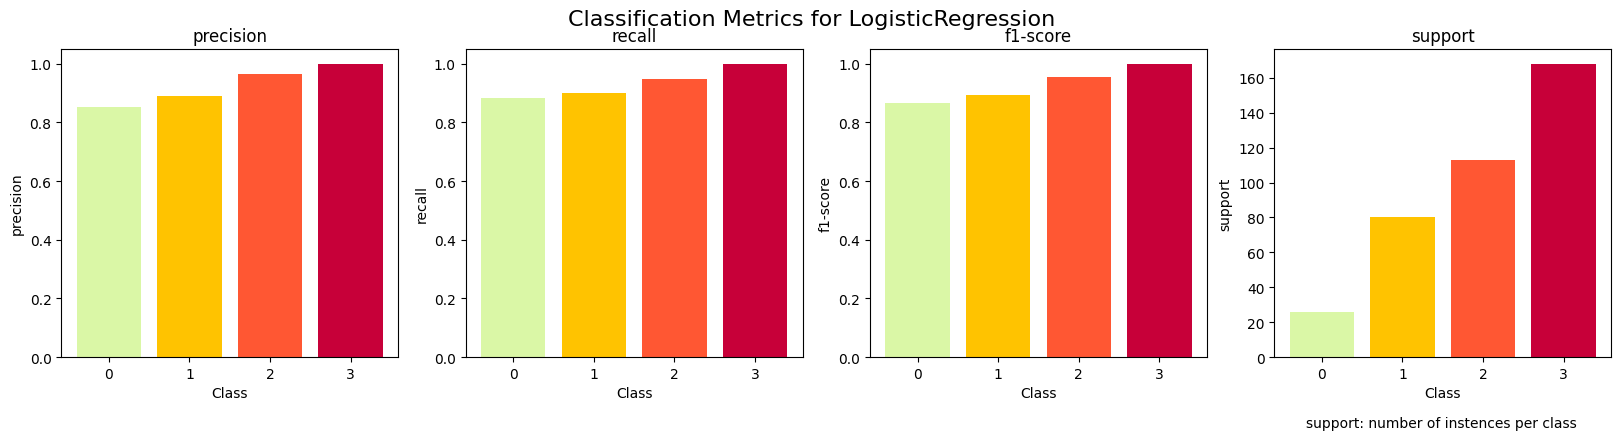

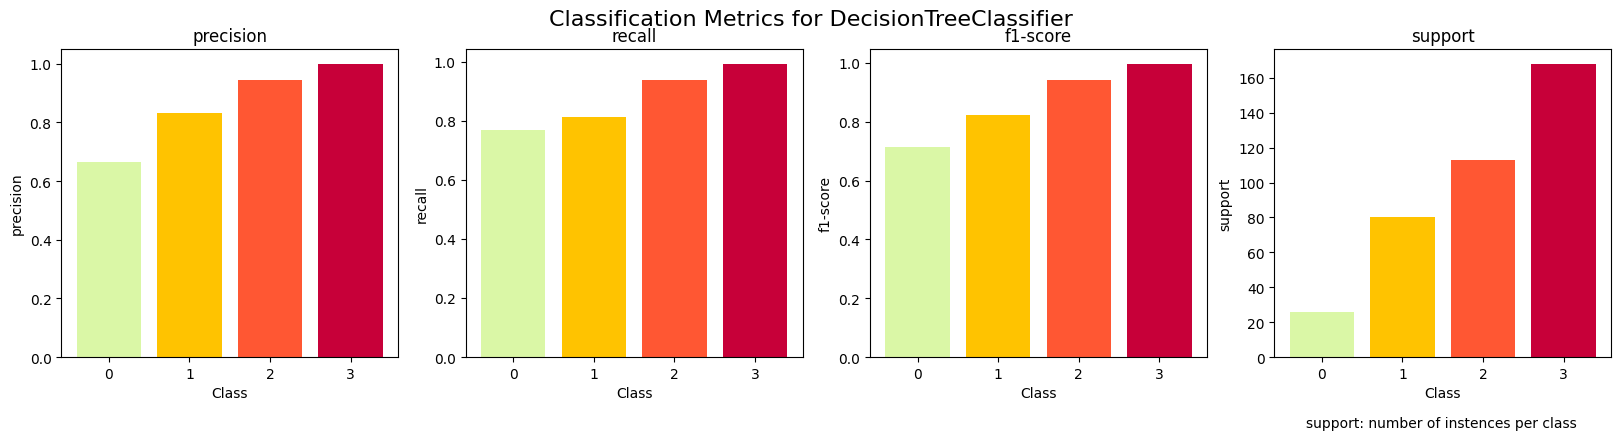

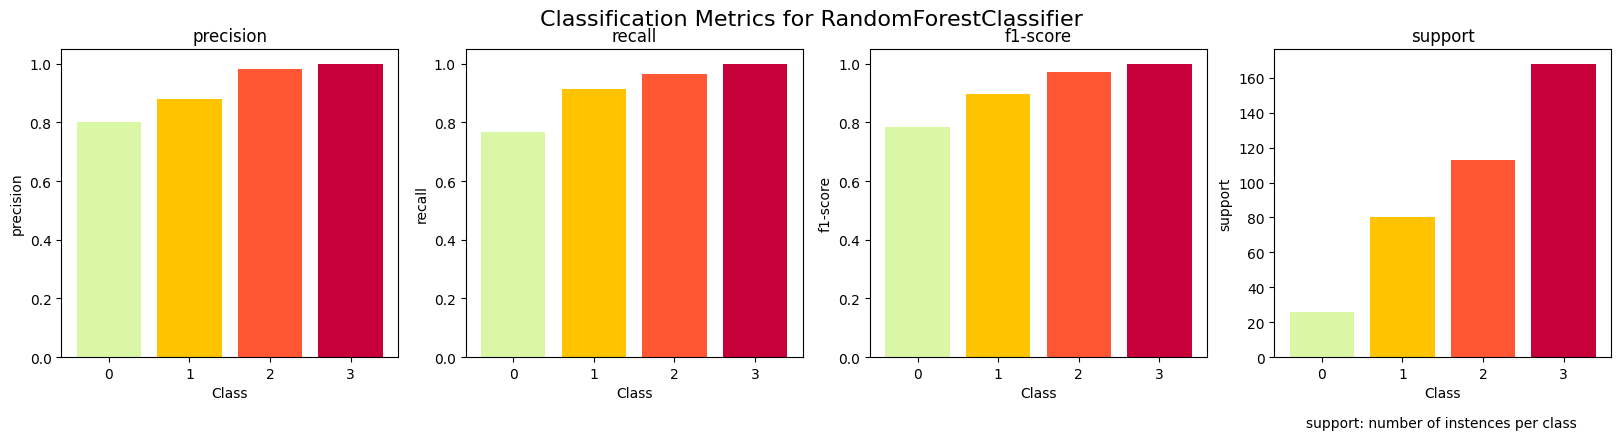

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# only for the classification
plot_model_performances(
    X_train_scaled=X_train_scaled, 
    y_train=y_train, 
    models={
        "LogisticRegression": LogisticRegression(), 
        "DecisionTreeClassifier":DecisionTreeClassifier(), 
        "RandomForestClassifier":RandomForestClassifier()
        }, 
    colors=["#DAF7A6", "#FFC300", "#FF5733", "#C70039"], 
    random_state=global_rand_state, 
    )

### Base on the performance I'll choose random forest classifier

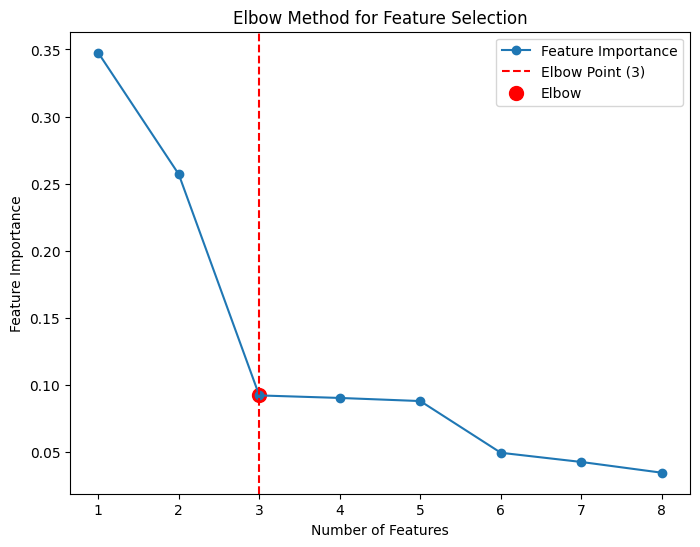

In [10]:
select_features_kneed, sorted_feature_names_based_on_feature_importance = \
    select_features_elbow_method(
        X_train_scaled=X_train_scaled, 
        y_train=y_train, 
        best_model=RandomForestClassifier(),
        plot_enable=True
        )

In [11]:
feature_selection_elbow_cache = {}
feature_selection_elbow_cache["selected_features"] = select_features_kneed
caches.append(feature_selection_elbow_cache)

In [12]:
sorted_feature_names_based_on_feature_importance

Index(['CO', 'Proximity_to_Industrial_Areas', 'Temperature', 'SO2', 'NO2',
       'Population_Density', 'Humidity', 'PM10'],
      dtype='object')

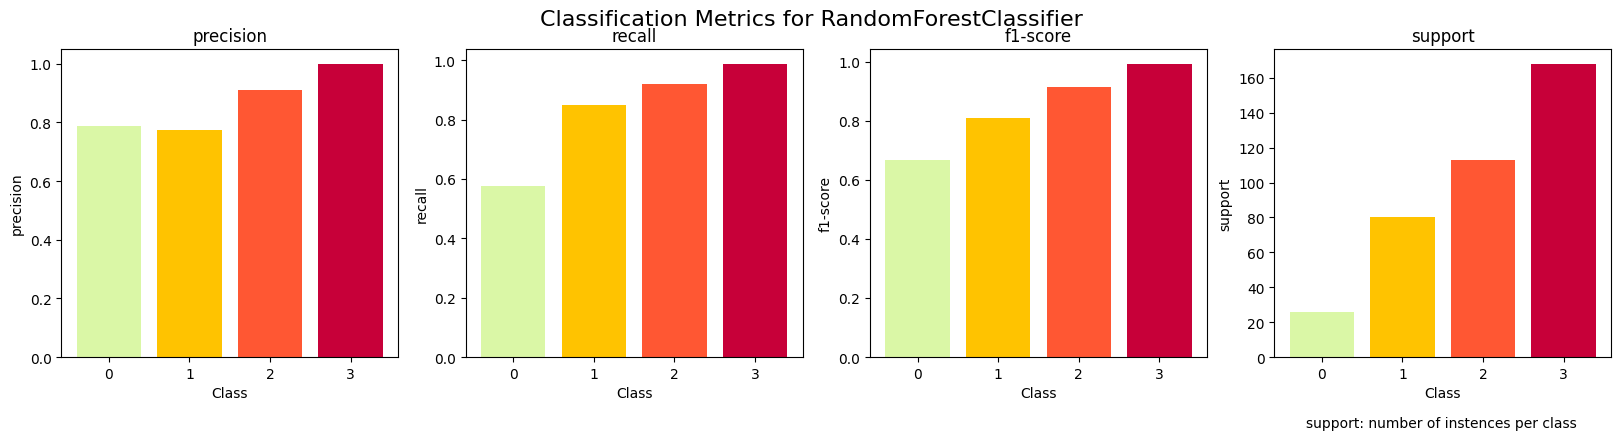

In [13]:
from sklearn.ensemble import RandomForestClassifier

# only for the classification
plot_model_performances(
    X_train_scaled=X_train_scaled[select_features_kneed], 
    y_train=y_train, 
    models={
        "RandomForestClassifier":RandomForestClassifier(),
        }, 
    colors=["#DAF7A6", "#FFC300", "#FF5733", "#C70039"], 
    random_state=global_rand_state, 
    )

### Not satisfied

### Test manually

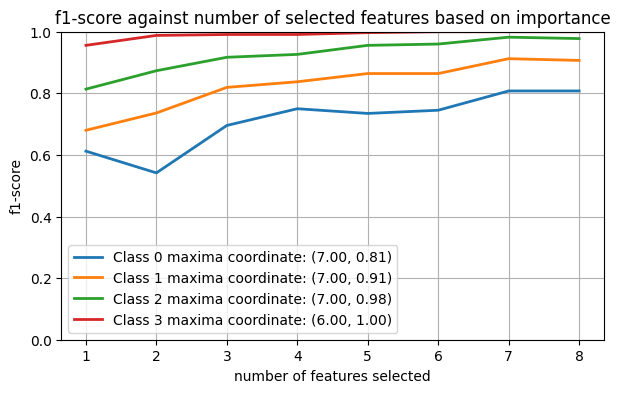

['CO',
 'Proximity_to_Industrial_Areas',
 'Temperature',
 'SO2',
 'NO2',
 'Population_Density',
 'Humidity']

In [14]:
# for classification only
final_selected_features = select_features_metric_method(
                            X_train_scaled=X_train_scaled, 
                            y_train=y_train, 
                            best_model=RandomForestClassifier(), 
                            random_state=global_rand_state, 
                            sorted_feature_names_based_on_feature_importance=sorted_feature_names_based_on_feature_importance,
                            selector="f1-score",
                            plot_enable=True
                            )
final_selected_features

In [15]:
feature_selection_metric_cache = {}
feature_selection_metric_cache["selected_features"] = final_selected_features
caches.append(feature_selection_metric_cache)

### All steps for preprocessing is complete

In [16]:
import pickle
# save the caches for later use in production
with open("./production/caches.pkl", "wb") as f:
    pickle.dump(caches, f)
    f.close()

In [17]:
X_train_selected = X_train_scaled[final_selected_features]
X_test_selected = X_test_scaled[final_selected_features]

In [18]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, criterion='entropy', random_state=global_rand_state)
model.fit(X_train_selected, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, random_state=66)

In [19]:
y_true = y_test
y_pred = model.predict(X_test_selected)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.18      0.31        76
           1       0.71      0.83      0.77       195
           2       0.89      0.98      0.93       276
           3       1.00      1.00      1.00       421

    accuracy                           0.90       968
   macro avg       0.90      0.75      0.75       968
weighted avg       0.91      0.90      0.88       968



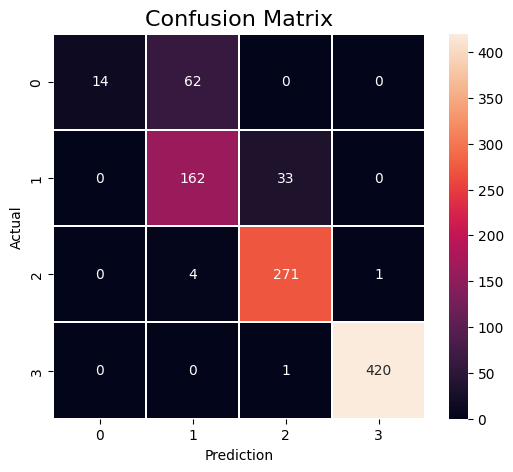

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:\n", classification_report(y_true=y_true, y_pred=y_pred))
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), annot=True, linewidths=0.1, fmt="d")
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show(block=False)

<Axes: xlabel='Air Quality', ylabel='count'>

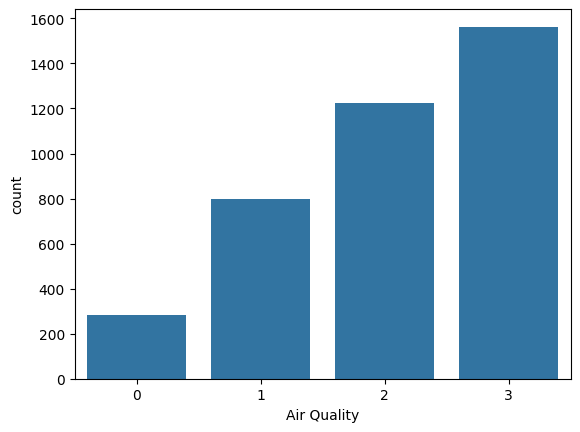

In [21]:
# check class imbalanceness
sns.countplot(x=y_train)

In [22]:
# Oversampling by adding synthetic data for the trainset
from imblearn.over_sampling import SMOTE  
smote = SMOTE(sampling_strategy='auto', random_state=global_rand_state, k_neighbors=3)  
X_train_smot, y_train_smot = smote.fit_resample(X_train_selected, y_train)

<Axes: xlabel='Air Quality', ylabel='count'>

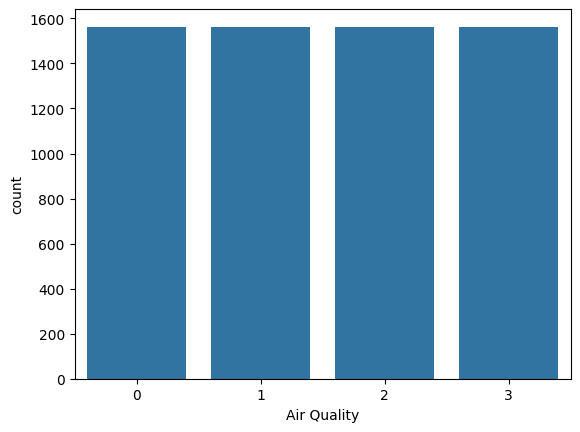

In [23]:
# check class imbalanceness
sns.countplot(x=y_train_smot)

In [24]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, criterion='entropy')
model.fit(X_train_smot, y_train_smot)

RandomForestClassifier(criterion='entropy', max_depth=3)

In [25]:
y_true = y_test
y_pred = model.predict(X_test_selected)

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.83      0.73        76
           1       0.88      0.69      0.77       195
           2       0.91      0.97      0.94       276
           3       1.00      1.00      1.00       421

    accuracy                           0.92       968
   macro avg       0.86      0.87      0.86       968
weighted avg       0.92      0.92      0.91       968



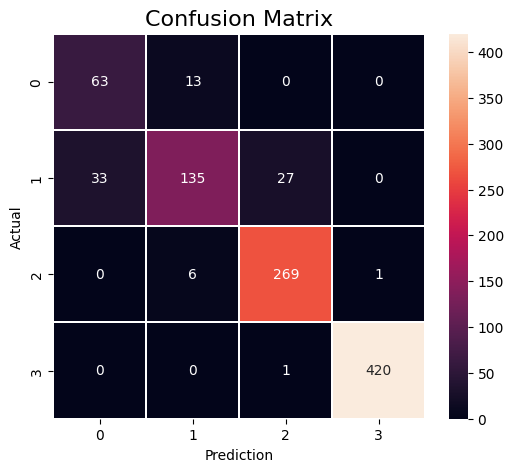

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:\n", classification_report(y_true=y_true, y_pred=y_pred))
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), annot=True, linewidths=0.1, fmt="d")
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show(block=False)

# MLFlow

In [27]:
import mlflow
import mlflow.pyfunc
import pandas as pd
import numpy as np
# from fastapi import FastAPI, HTTPException
# from pydantic import BaseModel
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import logging

In [28]:
# Initialize MLflow client
mlflow.set_tracking_uri("http://localhost:5000")  # Set your MLflow server URI
client = mlflow.tracking.MlflowClient()

In [29]:
class RFModelProduction(mlflow.pyfunc.PythonModel):
    def __init__(self, **kwargs):
        self.model = RandomForestClassifier(**kwargs)

    def _reverse_dic(self, dic):
        reversed_global_map_ = {}
        try:
            for key, value in dic.items():
                reversed_global_map_[value] = key
        except:
            raise ValueError("Dictonary ca not have duplicate keys.")
        return reversed_global_map_

    
    def fit(self, X, y):
        logging.info("Training model...")
        self.model.fit(X, y)
        logging.info("Model Training Completed")

    def predict(self, context, model_input):
        return self.model.predict(model_input)
    
    def predict_production(self, model_input):
        reversed_global_map_ = self._reverse_dic(global_map_)
        return np.array([reversed_global_map_[pred] for pred in self.model.predict(model_input)])

In [30]:
model_wrapper = RFModelProduction(
                    n_estimators=100, 
                    max_depth=3, 
                    criterion='entropy', 
                    random_state=global_rand_state
                    )

In [31]:
# Model Training
with mlflow.start_run(run_name="Model_Training") as train_run:
    model_wrapper = RFModelProduction()
    model_wrapper.fit(X_train_smot, y_train_smot)
    
    logging.info("Logging model to MLflow...")
    mlflow.pyfunc.log_model("random_forest_model", python_model=model_wrapper)
    logging.info("Model Logged to MLflow")
    
    model_name = "random_forest_model"
    with open("./production/model_name.txt", "w") as f:
        f.write(model_name)
        f.close()

    try:
        # Try to create the registered model (only needed once)
        client.create_registered_model(model_name)
        logging.info(f"Registered model '{model_name}' created.")
    except mlflow.MlflowException as e:
        if "RESOURCE_ALREADY_EXISTS" in str(e):
            logging.info(f"Model '{model_name}' already exists, skipping creation.")
        else:
            raise  TypeError("Unknown Error Occured!")

    # Now, create a new version of the model
    model_version = client.create_model_version(
        name=model_name, 
        source=f"runs:/{train_run.info.run_id}/random_forest_model",
        run_id=train_run.info.run_id
    )

    client.transition_model_version_stage(
        name=model_name, 
        version=model_version.version, 
        stage="Production"
    )

    logging.info(f"Model '{model_name}' version {model_version.version} registered and moved to Production.")
    
# Model Evaluation
with mlflow.start_run(run_name="Model_Evaluation") as eval_run:
    logging.info("Loading model from MLflow registry...")
    MODEL_URI = f"models:/{model_name}/production"
    model = mlflow.pyfunc.load_model(MODEL_URI)
    logging.info("Model Loaded from MLflow")
    
    logging.info("Evaluating model...")
    predictions = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_text(report, "classification_report.txt")
    logging.info("Model Evaluation Completed")

2025/02/03 02:15:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/03 02:15:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_model, version 19
C:\Users\Eshan\AppData\Local\Temp\ipykernel_17280\2190505969.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
2025/02/03 02:15:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Model_Training at: http://localhost:5000/#/experiments/0/runs/04465de1bd6c4dcdb740791257270b75.
2

2025/02/03 02:15:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run Model_Evaluation at: http://localhost:5000/#/experiments/0/runs/707015cc214646e690932ec0b8586557.
2025/02/03 02:15:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


In [32]:
X_req, y = load_raw_dataset(file_path="./data/air_pollution_dataset", target="Air Quality")
X_req_np = X_req.iloc[0:10, :].values
y_req_np = y[0:10].map(global_map_).values
print(X_req_np)

[[ 29.8   59.1    5.2   17.9   18.9    9.2    1.72   6.3  319.  ]
 [ 28.3   75.6    2.3   12.2   30.8    9.7    1.64   6.   611.  ]
 [ 23.1   74.7   26.7   33.8   24.4   12.6    1.63   5.2  619.  ]
 [ 27.1   39.1    6.1    6.3   13.5    5.3    1.15  11.1  551.  ]
 [ 26.5   70.7    6.9   16.    21.9    5.6    1.01  12.7  303.  ]
 [ 39.4   96.6   14.6   35.5   42.9   17.9    1.82   3.1  674.  ]
 [ 41.7   82.5    1.7   15.8   31.1   12.7    1.8    4.6  735.  ]
 [ 31.    59.6    5.    16.8   24.2   13.6    1.38   6.3  443.  ]
 [ 29.4   93.8   10.3   22.7   45.1   11.8    2.03   5.4  486.  ]
 [ 33.2   80.5   11.1   24.4   32.    15.3    1.69   4.9  535.  ]]


In [33]:
preprocess_production(X_req_=X_req_np, pickle_loc="./production/caches.pkl")

,CO,Proximity_to_Industrial_Areas,Temperature,SO2,NO2,Population_Density,Humidity
0,0.495373,-0.619680,0.012842,-0.071800,-0.843610,-1.149102,-0.674570
1,0.337152,-0.705848,-0.225796,0.009090,0.575649,0.799746,0.389421
2,0.317374,-0.935629,-1.053074,0.478252,-0.187650,0.853139,0.331385
3,-0.631957,0.759009,-0.416706,-0.702741,-1.487643,0.399298,-1.964255
4,-0.908845,1.218572,-0.512162,-0.654207,-0.485813,-1.255889,0.073448
5,0.693150,-1.538806,1.540124,1.335686,2.018761,1.220217,1.743590
6,0.653595,-1.107965,1.906035,0.494430,0.611429,1.627339,0.834362
7,-0.177069,-0.619680,0.203752,0.640032,-0.211503,-0.321509,-0.642328
8,1.108483,-0.878184,-0.050795,0.348828,2.281145,-0.034521,1.563035
9,0.436040,-1.021797,0.553754,0.915058,0.718768,0.292511,0.705394
